In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from a2_utils import *
from a3_utils import *
from UZ_utils import *
import os

# Exercise 1: Image derivatives

In [2]:
def filter(I, kernel):

    return cv2.filter2D(I, -1, kernel)


### b) Implement the function gaussdx(sigma) that works the same as function gauss from the previous assignment.

In [3]:
def gauss(sigma):
    size = int(2 * np.ceil(3 * sigma) + 1)
    g = []

    for i in range(size):
        x = i - (size - 1) / 2 
        value = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
        g.append(value)
        
    g = np.array(g)  
    return (g / np.sum(g)).reshape(1,-1)

In [4]:
def gaussdx(sigma):
    size = int(2 * np.ceil(3 * sigma) + 1)
    g = []

    for i in range(size):
        x = i - (size - 1) / 2
        value = (-1 / (np.sqrt(2 * np.pi) * sigma ** 3)) * x * np.exp(-(x**2) / (2 * sigma**2))
        g.append(value)

    g = np.array(g)

    return (g / np.sum(np.abs(g))).reshape(1,-1)
    

### c) The properties of the filter can be analyzed by using an impulse response function.This is performed as a convolution of the filter with a Dirac delta function. 

In [5]:
impulse = np.zeros((50, 50))
impulse[25, 25] = 1

In [6]:
G = gauss(3)
GT = G.T
G = np.flip(G)
GT = np.flip(GT)

D = gaussdx(3)
DT = D.T
D = np.flip(D)
DT = np.flip(DT)

In [7]:
G_Gt = filter(filter(impulse, G), GT)
G_Dt = filter(filter(impulse, G), DT)
D_Gt = filter(filter(impulse, D), GT)
Gt_D = filter(filter(impulse, GT), D)
Dt_G = filter(filter(impulse, DT), G)

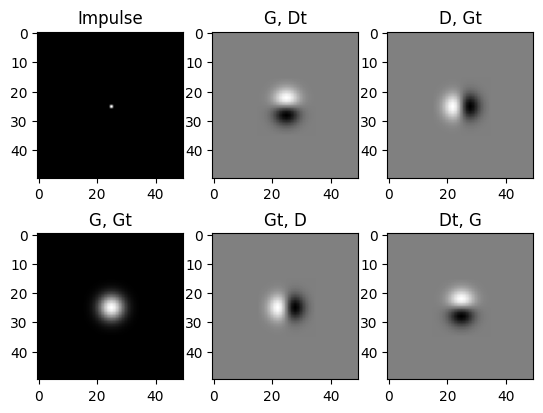

In [8]:
plt.subplot(2, 3, 1)
plt.imshow(impulse, cmap='gray')
plt.title('Impulse')
plt.subplot(2, 3, 2)
plt.imshow(G_Dt, cmap='gray')
plt.title('G, Dt')
plt.subplot(2, 3, 3)
plt.imshow(D_Gt, cmap='gray')
plt.title('D, Gt')
plt.subplot(2, 3, 4)
plt.imshow(G_Gt, cmap='gray')
plt.title('G, Gt')
plt.subplot(2, 3, 5)
plt.imshow(Gt_D, cmap='gray')
plt.title('Gt, D')
plt.subplot(2, 3, 6)
plt.imshow(Dt_G, cmap='gray')
plt.title('Dt, G')
plt.show()

### (d) Implement a function that uses functions gauss and gaussdx to compute both partial derivatives of a given image with respect to x and with respect to y.

In [9]:
def first_derivative(I, sigma=1):

    G = gauss(sigma)
    GT = G.T
    G = np.flip(G)
    GT = np.flip(GT)
    
    D = gaussdx(sigma)
    DT = D.T
    D = np.flip(D)
    DT = np.flip(DT)
    
    dx = filter(filter(I, GT), D)
    dy = filter(filter(I, DT), G)
    
    return dx, dy
        

In [10]:
def second_derivative(I, sigma=1):
    
    I_dx, I_dy = first_derivative(I, sigma)
    I_dxx, I_dyx = first_derivative(I_dx, sigma)
    I_dxy, I_dyy = first_derivative(I_dy, sigma)
    
    return I_dxx, I_dxy, I_dyy

In [11]:
def gradient_magnitude(I, sigma=1):

    dx, dy = first_derivative(I, sigma)
    m = np.sqrt(dx**2 + dy**2)
    a = np.arctan2(dy,dx)

    return m, a

In [12]:
museum = imread_gray('images/museum.jpg')
I_x, I_y = first_derivative(museum, 1)
I_mag, I_dir = gradient_magnitude(museum, 1)
I_xx, I_xy, I_yy = second_derivative(museum, 1)

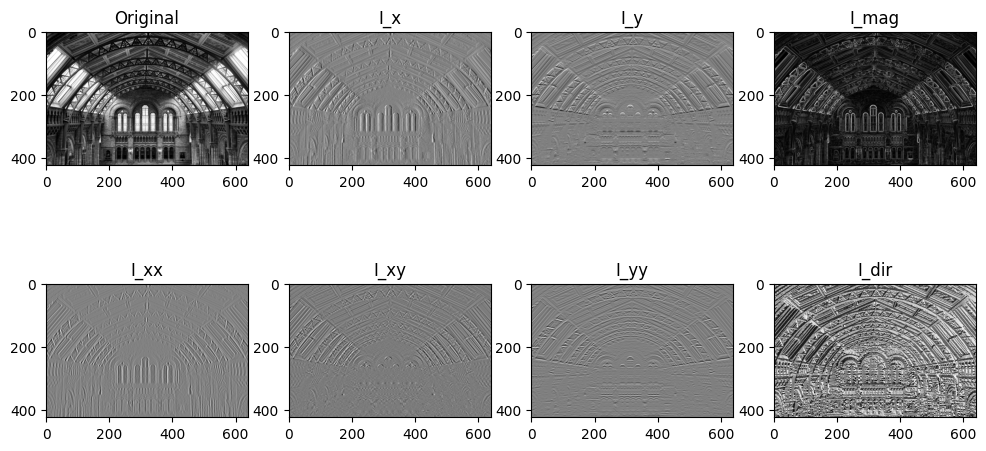

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1)
plt.imshow(museum, cmap='gray')
plt.title('Original')
plt.subplot(2, 4, 2)
plt.imshow(I_x, cmap='gray')
plt.title('I_x')
plt.subplot(2, 4, 3)
plt.imshow(I_y, cmap='gray')
plt.title('I_y')
plt.subplot(2, 4, 4)
plt.imshow(I_mag, cmap='gray')
plt.title('I_mag')
plt.subplot(2, 4, 5)
plt.imshow(I_xx, cmap='gray')
plt.title('I_xx')
plt.subplot(2, 4, 6)
plt.imshow(I_xy, cmap='gray')
plt.title('I_xy')
plt.subplot(2, 4, 7)
plt.imshow(I_yy, cmap='gray')
plt.title('I_yy')
plt.subplot(2, 4, 8)
plt.imshow(I_dir, cmap='gray')
plt.title('I_dir')
plt.show()



### (e) Gradient information is often used in image recognition. Extend your image retrieval system from the previous assignment to use a simple gradient-based feature instead of color histograms. 

In [14]:
def compare_histograms(H1, H2, measure:str):

    distance = 0
    if measure == "L2":
        difference = (H1 - H2) ** 2
        distance = np.sqrt(np.sum(difference))
    elif measure == "X2":
        e = 1e-10
        difference = (H1 - H2) ** 2
        sum = H1 + H2 + e
        distance = 0.5 * np.sum((difference / sum))
    elif measure == "I":
        minimum = np.minimum(H1, H2)
        distance = 1 - np.sum(minimum)
    elif measure == "H":
        sqrt_H1 = np.sqrt(H1)
        sqrt_H2 = np.sqrt(H2)
        difference = (sqrt_H1 - sqrt_H2)**2
        distance = np.sqrt(0.5 * np.sum(difference))
        
    return round(distance,2)

In [15]:
def divide_into_grid(image, grid_size):
    
    cells = np.array_split(image, grid_size[0], axis=0)
    cells = [np.array_split(cell, grid_size[1], axis=1) for cell in cells]
    grid_cells = [cell for row in cells for cell in row]

    return grid_cells


In [16]:
def histogram(mags, angs, n_bins):
    
    hist = np.zeros(n_bins)
    for m, a in zip(mags.reshape(-1), angs.reshape(-1)):
        hist[a] += m

    return hist

In [17]:
def feature(image, sigma, n_bins):
    magnitudes, angles = gradient_magnitude(image, sigma)
    angle_values = np.linspace(-np.pi, np.pi, n_bins)
    angles = np.digitize(angles, bins=angle_values) - 1

    mag_cells = divide_into_grid(magnitudes, (n_bins, n_bins))
    angle_cells = divide_into_grid(angles, (n_bins, n_bins))

    features = []
    for m, a in zip(mag_cells, angle_cells):
        hist = histogram(m, a, n_bins)
        features.extend(hist)

    return np.array(features)
    

In [18]:
def compute_features(directory, sigma, n_bins):
    features = {}
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = imread_gray(image_path)
        f = feature(image, sigma, n_bins)
        features[image_path] = f
    return features

In [19]:
def  image_retrieval(directory, image, sigma, n_bins, napaka):
    features = compute_features(directory, sigma, n_bins)
    F = feature(image, sigma, n_bins)

    errors = {}

    for image_path, f in features.items():
        e = compare_histograms(F,f,napaka)
        errors[image_path] = e

    return errors, features

In [20]:
def ret_5(directory, image, sigma, n_bins, napaka):
    errors, features = image_retrieval(directory, image, sigma, n_bins, napaka)
    sorted_errors = dict(sorted(errors.items(), key=lambda item: item[1]))
    errors5 = {}
    features5 = {}
    i = 0
    for image_path, err in sorted_errors.items():
        errors5[image_path] = err
        features5[image_path] = features[image_path]
        i+=1

        if i == 6:
            break
    return errors5, features5

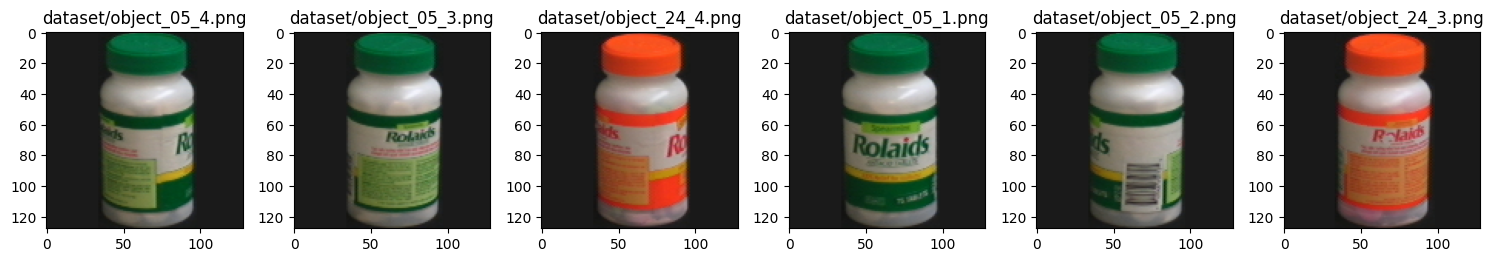

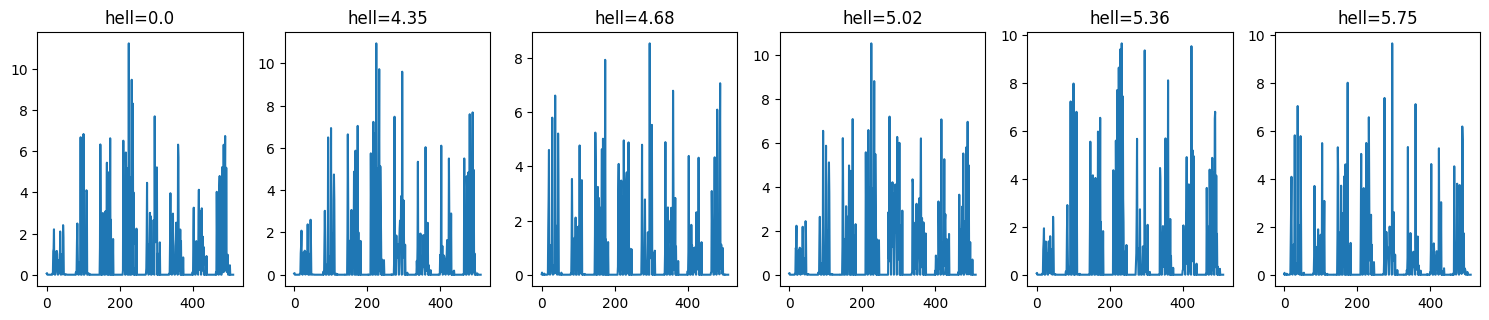

In [21]:
image = imread_gray("dataset/object_05_4.png")

err, hists = ret_5("dataset/", image, 1, 8, "H")

plt.figure(figsize=(15, 10)) 
for idx, (image_path, e) in enumerate(err.items()):
    img = cv2.imread(image_path)
    plt.subplot(1, 6, idx+1) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
    plt.title(image_path)
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6)) 
for idx, (image_path, e) in enumerate(err.items()):
    hist = hists[image_path]
    plt.subplot(2, 6, idx+7) 
    plt.plot(hist)
    plt.title(f"hell={e}")
    
plt.tight_layout()
plt.show()

# Exercise 2: Edges in images


### (a) Create a function findedges that accepts an image I, and the parameters sigma and theta

In [22]:
def findedges(I, sigma, theta):
    
    I_mag, _ = gradient_magnitude(I, sigma)
    I_mag_bin = np.where(I_mag >= theta, 1, 0)
    I_mag = np.where(I_mag >= theta, I_mag, 0)
    
    return I_mag, I_mag_bin

In [23]:
museum = imread_gray("images/museum.jpg")
mt1, mt1_bin = findedges(museum, 1, 0.04)
mt2, mt2_bin = findedges(museum, 1, 0.1)
mt3, mt3_bin = findedges(museum, 1, 0.16)

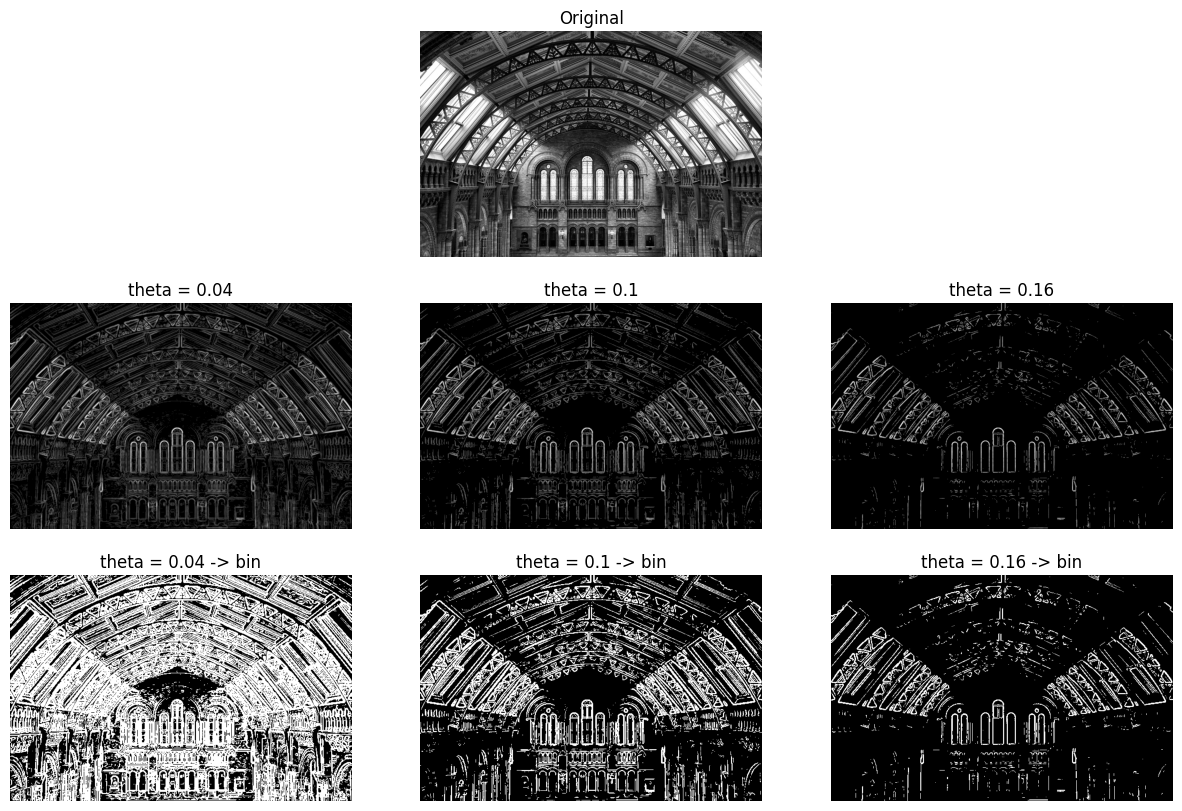

In [24]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 2)
plt.imshow(museum, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(3, 3, 4)
plt.imshow(mt1, cmap='gray')
plt.title('theta = 0.04')
plt.axis('off')
plt.subplot(3, 3, 5)
plt.imshow(mt2, cmap='gray')
plt.title('theta = 0.1')
plt.axis('off')
plt.subplot(3, 3, 6)
plt.imshow(mt3, cmap='gray')
plt.title('theta = 0.16')
plt.axis('off')
plt.subplot(3, 3, 7)
plt.imshow(mt1_bin, cmap='gray')
plt.title('theta = 0.04 -> bin')
plt.axis('off')
plt.subplot(3, 3, 8)
plt.imshow(mt2_bin, cmap='gray')
plt.title('theta = 0.1 -> bin')
plt.axis('off')
plt.subplot(3, 3, 9)
plt.imshow(mt3_bin, cmap='gray')
plt.title('theta = 0.16 -> bin')
plt.axis('off')
plt.show()



### (b) Implement non-maxima suppression based on the image derivative magnitudes and angles.

In [25]:
def non_maxima_suppression(I, sigma, theta):
    I_mag, angles = gradient_magnitude(I,sigma)
    edges, edges_bin = findedges(I, sigma, theta)

    angles = angles * 180 / np.pi

    angles[angles < 0] += 360
    angles[angles > 360] -= 360
    angles = np.floor(angles / 22.5).astype(int) % 16
    
    
    
    for i in range(1,I.shape[0]-1):
        for j in range(1,I.shape[1]-1):

            angle = angles[i, j]
            neighbors = [0, 0]
            
            if angle in [15, 0]:
                neighbors = [I_mag[i, j+1], I_mag[i, j-1]]
            if angle in [1, 2]:
                neighbors = [I_mag[i + 1, j+1], I_mag[i-1, j-1]]
            if angle in [3, 4]:
                neighbors = [I_mag[i+1, j], I_mag[i-1, j]]
            if angle in [5, 6]:
                neighbors = [I_mag[i-1, j+1], I_mag[i+1, j-1]]
            if angle in [7, 8]:
                neighbors = [I_mag[i, j-1], I_mag[i, j+1]]  
            if angle in [9, 10]:
                neighbors = [I_mag[i-1, j-1], I_mag[i+1, j+1]]
            if angle in [11, 12]:
                neighbors = [I_mag[i-1, j], I_mag[i+1, j]]
            if angle in [13, 14]:
                neighbors = [I_mag[i+1, j-1], I_mag[i-1, j+1]] 

            if I_mag[i, j] < max(neighbors):
                edges[i, j] = 0
                edges_bin[i, j] = 0
                
    return edges, edges_bin

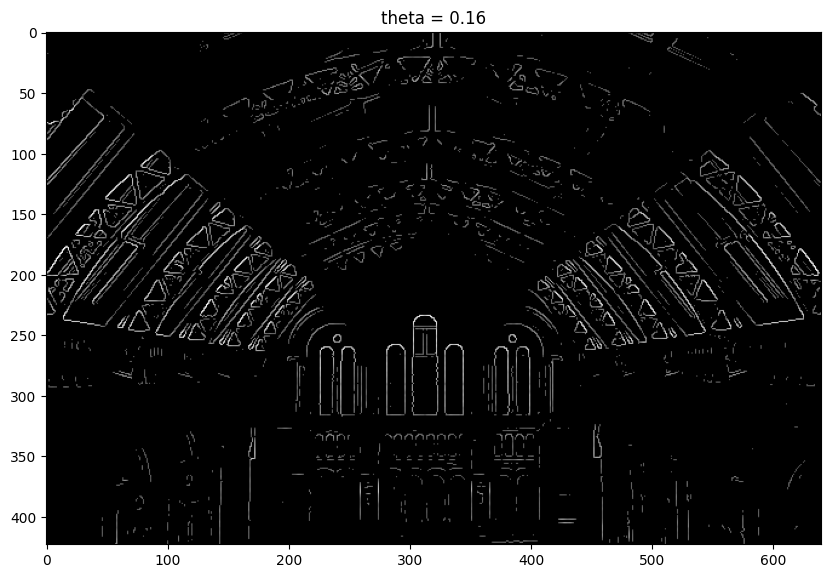

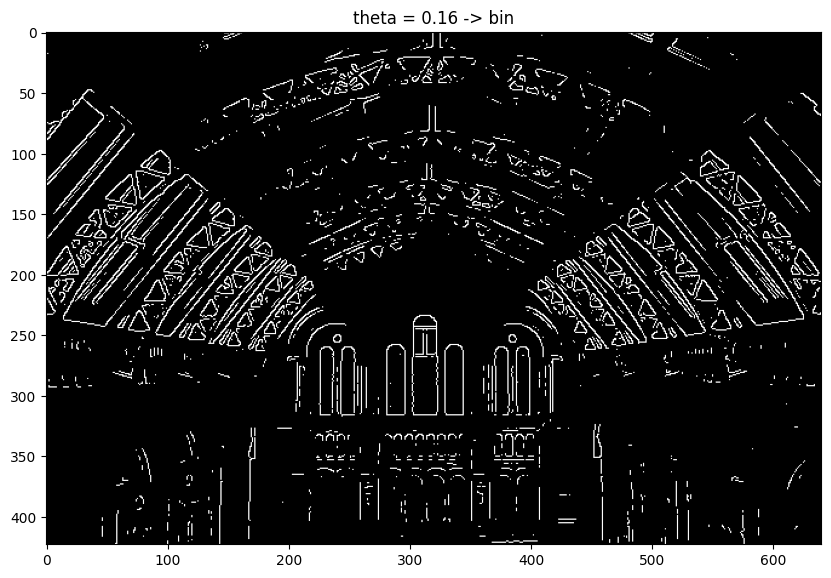

In [26]:
museum = imread_gray("images/museum.jpg")
museum_nmc, museum_nmc_bin  = non_maxima_suppression(museum, 1, 0.16)
plt.figure(figsize=(10, 8))
plt.imshow(museum_nmc, cmap='gray')
plt.title('theta = 0.16')
plt.show()
plt.figure(figsize=(10, 8))
plt.imshow(museum_nmc_bin, cmap='gray')
plt.title('theta = 0.16 -> bin')
plt.show()


### (c) Add the final step after performing non-maxima suppression along edges - Hysteresis

In [27]:
def hysteresis(I, sigma, tl, th):
    sup, _ = non_maxima_suppression(I, sigma, tl)
    output = sup.copy()
    
    output[sup < tl] = 0
    output[sup >= th] = 1
    
    output = (output * 255).astype(np.uint8)
    n, labels, _, _ = cv2.connectedComponentsWithStats(output, connectivity=8)

    output = output / 255.0

    for i in range(1, n): 
        component_mask = labels == i
        if np.any(output[component_mask]>=th): 
            output[component_mask] = 1
        else:
            output[component_mask] = 0
            

    return output
    

In [28]:
museum = imread_gray("images/museum.jpg")
_, edges_bin = findedges(museum, 1, 0.16)
_, museum_nmc_bin  = non_maxima_suppression(museum, 1, 0.16)
museum_hyst  = hysteresis(museum, 1, 0.04, 0.16)


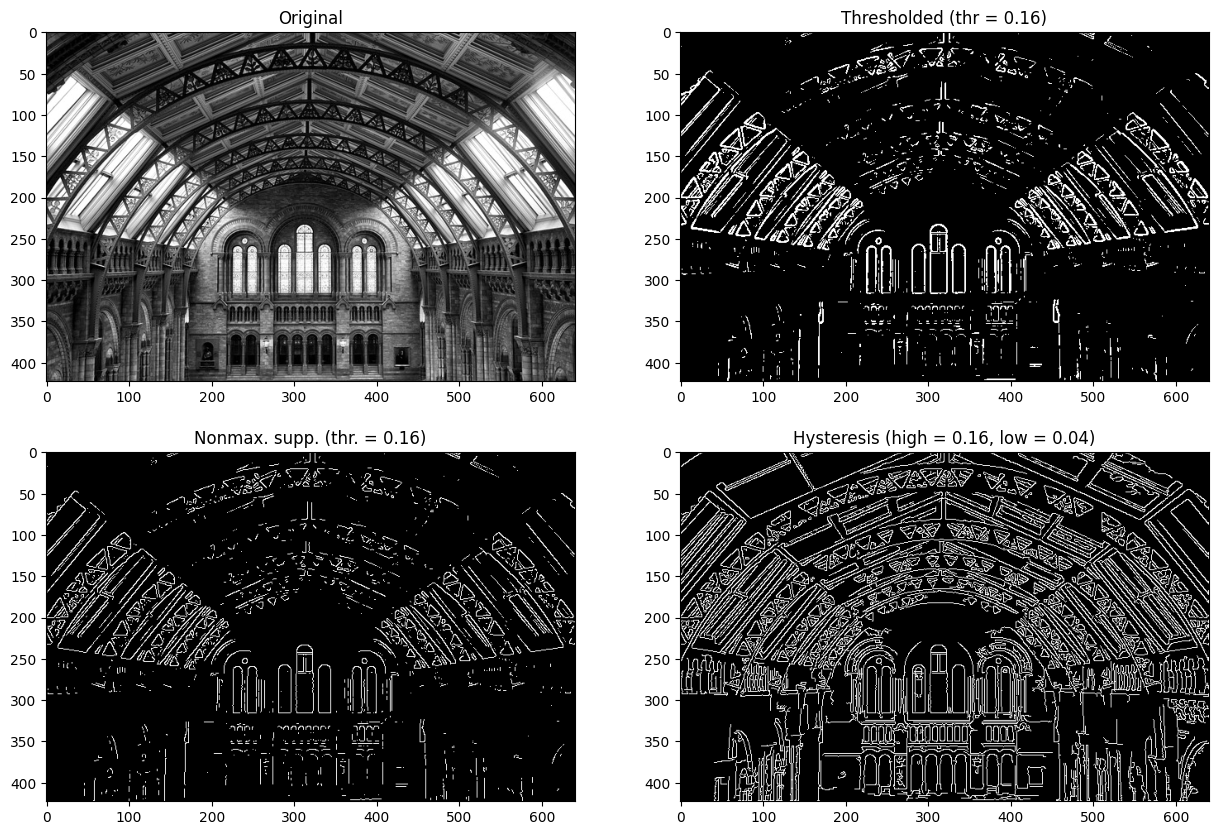

In [29]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(museum, cmap='gray')
plt.title('Original')
plt.subplot(2, 2, 2)
plt.imshow(edges_bin, cmap='gray')
plt.title('Thresholded (thr = 0.16)')
plt.subplot(2, 2, 3)
plt.imshow(museum_nmc_bin, cmap='gray')
plt.title('Nonmax. supp. (thr. = 0.16)')
plt.subplot(2, 2, 4)
plt.imshow(museum_hyst, cmap='gray')
plt.title('Hysteresis (high = 0.16, low = 0.04)')
plt.show()

# Exercise 3: Detecting lines

### (a) Create an accumulator array defined by the resolution on ρ and ϑ values. Calculate the sinusoid that represents all the lines that pass through some nonzero point.

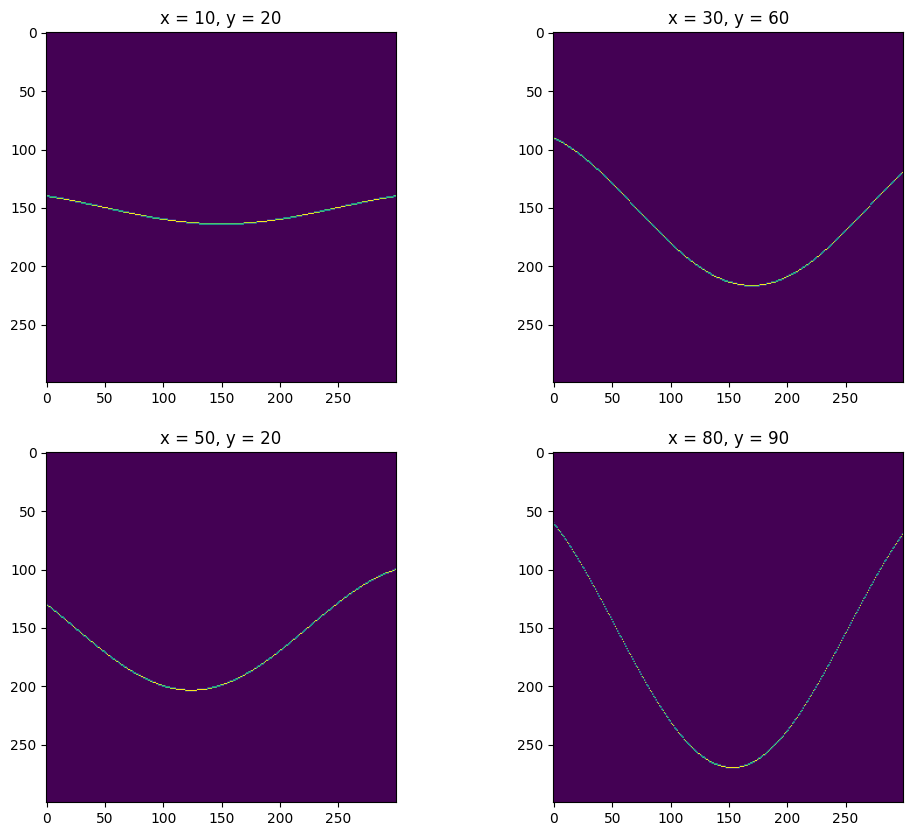

In [30]:
def accumulator_array(point, tn, thetas, rn, rhos):
    
    x, y = point
    accumulator = np.zeros((rn,tn))

    for j,theta in enumerate(thetas):
        val = x * np.cos(theta) + y * np.sin(theta) 
        i = np.digitize(val, rhos)
        accumulator[i, j] += 1
        
    return accumulator

def compute_accumulator_array(size, point):

    thetas = np.linspace(-np.pi/2, np.pi , num=size)
    rhos = np.linspace(-size/2, size/2, num=size)

    return accumulator_array(point, size, thetas, size, rhos)


acc10_10 = compute_accumulator_array(300, (10,10))
acc30_60 = compute_accumulator_array(300, (30,60))
acc50_20 = compute_accumulator_array(300, (50,20))
acc80_90 = compute_accumulator_array(300, (80,90))

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.imshow(acc10_10)
plt.title("x = 10, y = 20")
plt.subplot(2,2,2)
plt.imshow(acc30_60)
plt.title("x = 30, y = 60")
plt.subplot(2,2,3)
plt.imshow(acc50_20)
plt.title("x = 50, y = 20")
plt.subplot(2,2,4)
plt.imshow(acc80_90)
plt.title("x = 80, y = 90")
plt.show()




### (b) Implement the function hough_find_lines that accepts a binary image, the number of bins for ϑ and ρ (allow the possibility of them being different) and a threshold.


In [31]:
def hough_find_lines(image, theta_bins, rho_bins, thr):

    d =  np.sqrt(image.shape[0]**2 + image.shape[1]**2)
    accumulator = np.zeros((rho_bins,theta_bins))

    thetas = np.linspace(-np.pi/2, np.pi/2, num=theta_bins)
    rhos = np.linspace(-d, d, num=rho_bins)

    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if image[y,x] != 0:
                accumulator = accumulator + accumulator_array((x,y), theta_bins, thetas, rho_bins, rhos)
                
    return accumulator

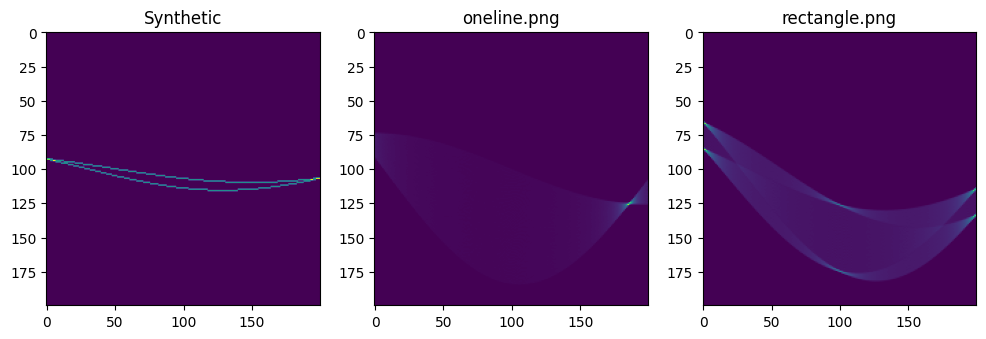

In [32]:
synthetic = np.zeros((100,100))
synthetic[10,10] = 1
synthetic[10,20] = 1
synthetic_acc = hough_find_lines(synthetic, 200, 200, 0)

oneline = imread_gray("images/oneline.png")
_, oneline = findedges(oneline, 1, 0.16)
oneline_acc = hough_find_lines(oneline, 200, 200, 0)
rectangle = imread_gray("images/rectangle.png")
_, rectangle = findedges(rectangle, 1, 0.16)
rectangle_acc = hough_find_lines(rectangle, 200, 200, 0)

plt.figure(figsize=(12, 10))
plt.subplot(1,3,1)
plt.imshow(synthetic_acc)
plt.title("Synthetic")
plt.subplot(1,3,2)
plt.imshow(oneline_acc)
plt.title("oneline.png")
plt.subplot(1,3,3)
plt.imshow(rectangle_acc)
plt.title("rectangle.png")
plt.show()


In [33]:
print(np.max(oneline_acc))

1223.0


### (c) Implement a function named nonmaxima_suppression_box that checks the neighborhood of each pixel and set it to 0 if it is not the maximum value in the neighborhood (only consider 8-neighborhood).

In [34]:
def  nonmaxima_suppression_box(x):

    X = np.pad(x, pad_width=1, mode='constant', constant_values=0)
    result = np.zeros((x.shape))
    rows, cols = X.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            
            neighbors = X[i - 1:i + 2, j - 1:j + 2]
            
            if X[i, j] == np.max(neighbors):
                result[i-1, j-1] = X[i, j]
                
    return result

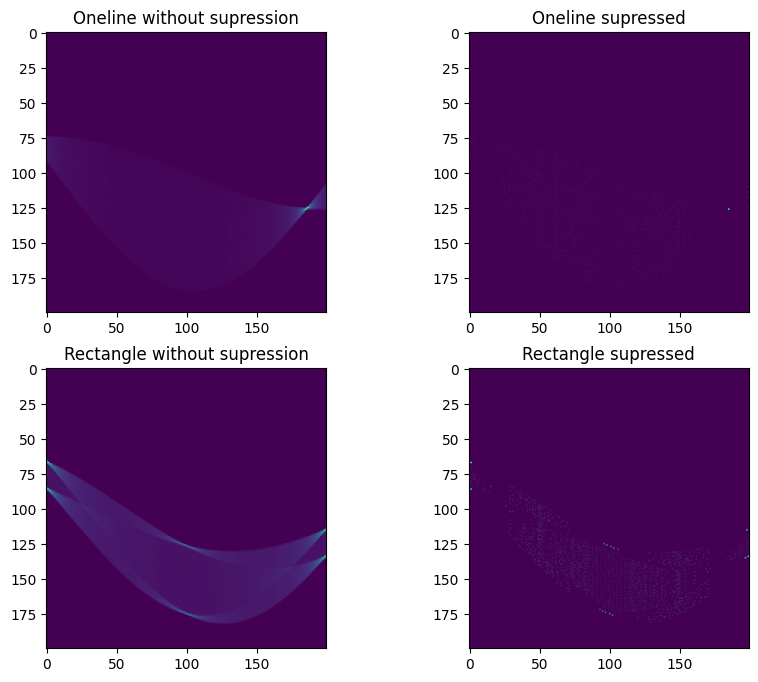

In [35]:
oneline_supressed = nonmaxima_suppression_box(oneline_acc)
rectangle_supressed = nonmaxima_suppression_box(rectangle_acc)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(oneline_acc)
plt.title('Oneline without supression')
plt.subplot(2,2,2)
plt.imshow(oneline_supressed)
plt.title('Oneline supressed')
plt.subplot(2,2,3)
plt.imshow(rectangle_acc)
plt.title('Rectangle without supression')
plt.subplot(2,2,4)
plt.imshow(rectangle_supressed)
plt.title('Rectangle supressed')
plt.show()

### (d) Search the parameter space and extract all the parameter pairs (ρ, ϑ) whose corresponding accumulator cell value is greater than a specified threshold threshold.


In [36]:
def find_pairs(image, theta_bins, rho_bins, thr, accumulator):
    
    supressed = nonmaxima_suppression_box(accumulator)

    print(np.max(supressed))
    d =  np.sqrt(image.shape[0]**2 + image.shape[1]**2)
    pairs = []

    thetas = np.linspace(-np.pi/2, np.pi/2, num=theta_bins)
    rhos = np.linspace(-d, d, num=rho_bins)
 
    for rho_idx, theta_idx in np.argwhere(supressed > thr):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        score = supressed[rho_idx, theta_idx]
        pairs.append([rho, theta, score])
                
    return pairs




In [37]:
synthetic = np.zeros((100,100))
synthetic[10,10] = 1
synthetic[10,20] = 1
oneline = imread_gray("images/oneline.png")
rectangle = imread_gray("images/rectangle.png")


10.0
1111.0
601.0


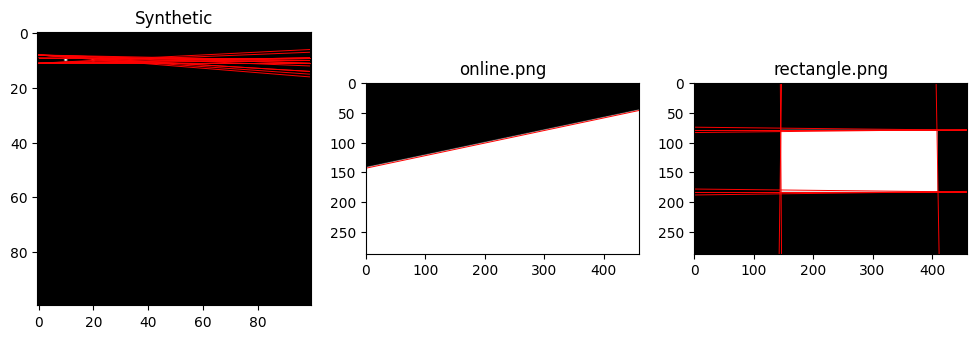

In [38]:
_, edges_syn = findedges(synthetic, 1, 0.1)
syn_acc = hough_find_lines(edges_syn, 500, 160, 0)
pairs_syn = find_pairs(synthetic ,500, 160, 9, syn_acc)
h_syn, w_syn = synthetic.shape

plt.figure(figsize=(12, 10))
plt.subplot(1,3,1)
plt.title("Synthetic")
plt.imshow(synthetic, cmap='gray')
for pair in pairs_syn:
    rho, theta,_ = pair
    draw_line(rho, theta, h_syn, w_syn)
    
h_one, w_one = oneline.shape
_, edges_one = findedges(oneline, 1, 0.1)
one_acc = hough_find_lines(edges_one, h_one, w_one, 0)
pairs_one = find_pairs(oneline, h_one, w_one, 250, one_acc)

plt.subplot(1,3,2)
plt.title("online.png")
plt.imshow(oneline, cmap='gray')
for pair in pairs_one:
    rho, theta,_  = pair
    draw_line(rho, theta, h_one, w_one)

h_rec, w_rec = rectangle.shape
_, edges_rec = findedges(rectangle, 1, 0.1)
rec_acc = hough_find_lines(edges_rec, h_rec, w_rec, 0)
pairs_rec = find_pairs(rectangle, h_rec, w_rec, 240, rec_acc )

plt.subplot(1,3,3)
plt.title("rectangle.png")
plt.imshow(rectangle, cmap='gray')
for pair in pairs_rec:
    rho, theta,_ = pair
    draw_line(rho, theta, h_rec, w_rec)
plt.show()

### (e) Detect lines on bricks.jpg and pier.jpg

In [39]:
bricks_gray = imread_gray("images/bricks.jpg")
pier_gray = imread_gray("images/pier.jpg")

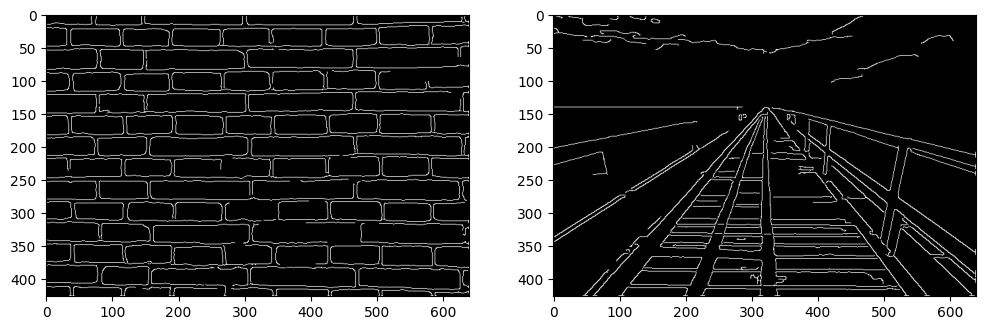

In [40]:
brick_hyst  = hysteresis(bricks_gray, 2, 0.1, 0.2)
pier_hyst  = hysteresis(pier_gray, 2, 0.03, 0.1)

plt.figure(figsize=(12, 10))
plt.subplot(1,2,1)
plt.imshow(brick_hyst, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(pier_hyst, cmap="gray")
plt.show()

1699.0
1071.0


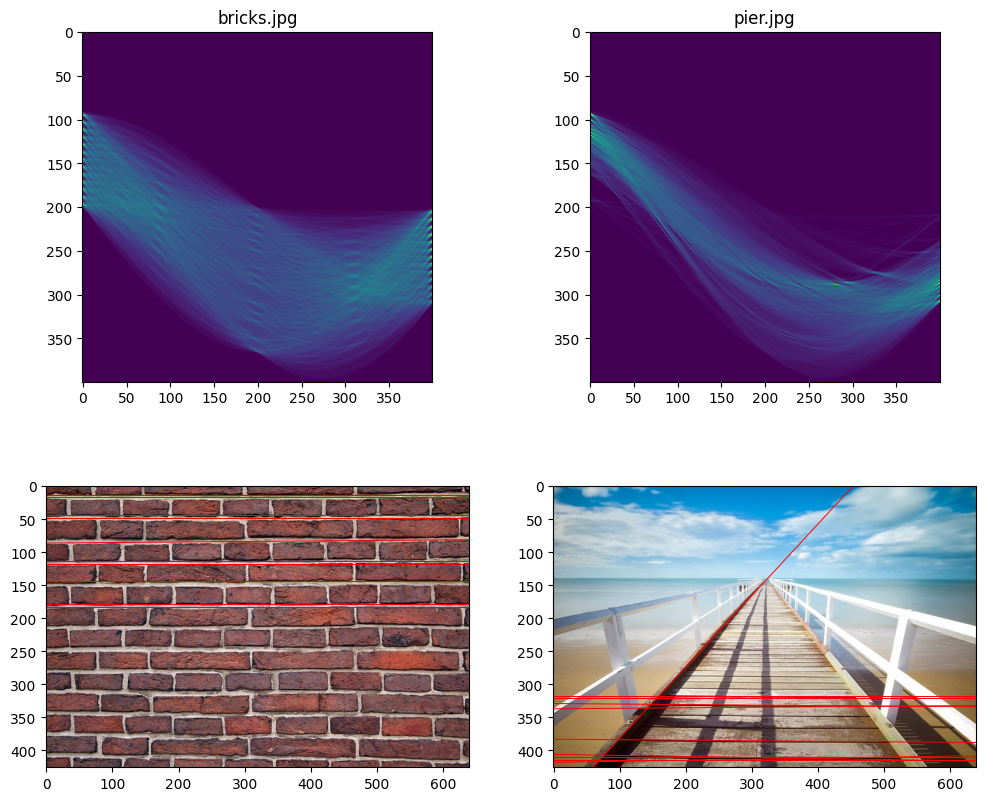

In [41]:
h_brick, w_brick = brick_hyst.shape
_, edges_brick = findedges(bricks_gray, 1, 0.1)
brick_acc = hough_find_lines(edges_brick, 400, 400, 0)
pairs_brick = find_pairs(brick_hyst, 400, 400, 0, brick_acc)
pairs_brick.sort(key=lambda x: x[2], reverse=True)

h_pier, w_pier = pier_hyst.shape
_, edges_pier = findedges(pier_gray, 1, 0.1)
pier_acc = hough_find_lines(edges_pier, 400, 400, 0)
pairs_pier = find_pairs(pier_hyst, 400, 400, 0, pier_acc)
pairs_pier.sort(key=lambda x: x[2], reverse=True)

bricks = cv2.imread("images/bricks.jpg")
bricks = cv2.cvtColor(bricks, cv2.COLOR_BGR2RGB)
pier = cv2.imread("images/pier.jpg")
pier = cv2.cvtColor(pier, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.title("bricks.jpg")
plt.imshow(brick_acc)
plt.subplot(2,2,2)
plt.title("pier.jpg")
plt.imshow(pier_acc)
plt.subplot(2,2,3)
plt.imshow(bricks)
for pair in pairs_brick[:10]:
    rho, theta,_ = pair
    draw_line(rho, theta, h_brick, w_brick)
plt.subplot(2,2,4)
plt.imshow(pier, cmap='gray')
for pair in pairs_pier[:10]:
    rho, theta,_ = pair
    draw_line(rho, theta, h_pier, w_pier)
plt.show()


### (f) Copy your implementation of the line detector to a new function and modify the algorithm so that it also accepts the matrix of edge angles. 

In [42]:
def find_pairs_with_angles(image, theta_bins, rho_bins, thr, edge_angles):
   
    _, edges = findedges(image, 1, 0.1)
    
    d = np.sqrt(image.shape[0]**2 + image.shape[1]**2) 
    accumulator = np.zeros((rho_bins, theta_bins))

    thetas = np.linspace(-np.pi/2, np.pi/2, num=theta_bins)
    rhos = np.linspace(-d, d, num=rho_bins)

    edge_angles = np.mod(edge_angles + np.pi / 2, np.pi) - np.pi / 2

    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i, j] > 0:  
                angle = edge_angles[i, j]
                theta_index = np.argmin(np.abs(thetas - angle))
                
                rho = j * np.cos(angle) + i * np.sin(angle)
                rho_index = np.digitize(rho, rhos)

                accumulator[rho_index, theta_index] += 1

    supressed = nonmaxima_suppression_box(accumulator)

    pairs = []
    for rho_idx, theta_idx in np.argwhere(supressed > thr):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        score = supressed[rho_idx, theta_idx]
        pairs.append([rho, theta, score])

    return pairs, accumulator


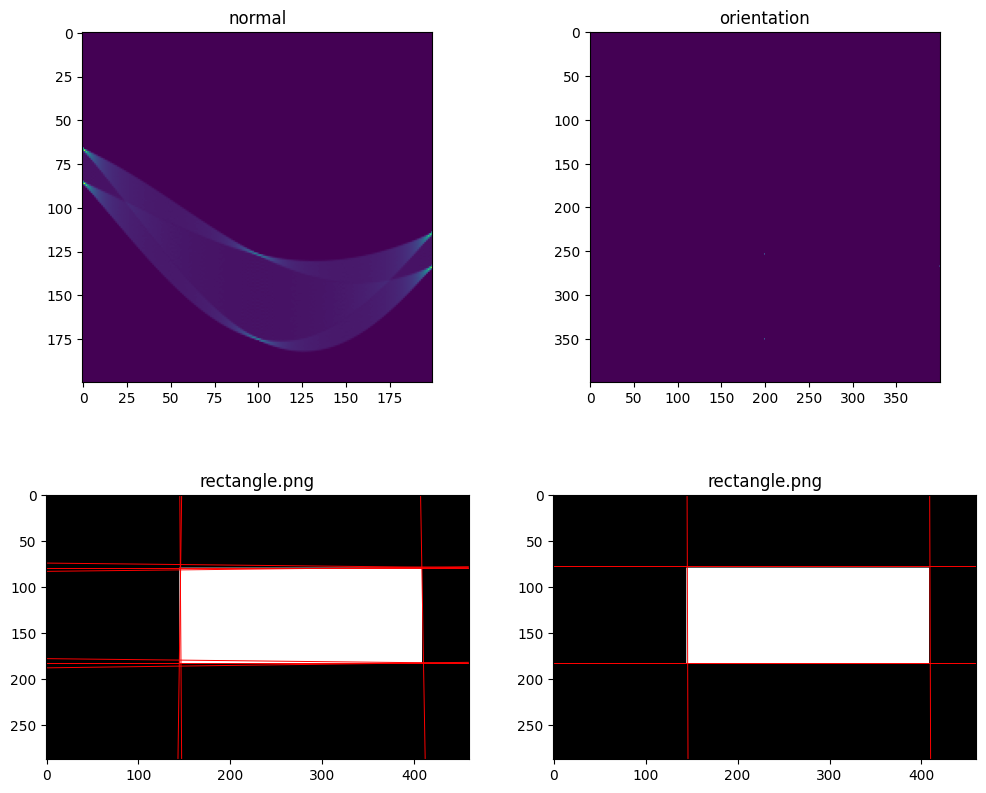

In [43]:
rectangle = imread_gray("images/rectangle.png")
_, angles = gradient_magnitude(rectangle, 1)
h_rec, w_rec = rectangle.shape
rec_acc = hough_find_lines(rectangle, 400, 400, 0)
pairs2_rec, rec_acc2 = find_pairs_with_angles(rectangle, 400, 400, 150, angles)

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.title("normal")
plt.imshow(rectangle_acc)
plt.subplot(2,2,2)
plt.imshow(rec_acc2)
plt.title("orientation")
plt.subplot(2,2,3)
plt.title("rectangle.png")
plt.imshow(rectangle, cmap='gray')
for pair in pairs_rec:
    rho, theta,_ = pair
    draw_line(rho, theta, h_rec, w_rec)
plt.subplot(2,2,4)
plt.title("rectangle.png")
plt.imshow(rectangle, cmap='gray')
for pair in pairs2_rec:
    rho, theta,_ = pair
    draw_line(rho, theta, h_rec, w_rec)
plt.show()



### (g)  Implement a Hough transform that detects circles of a fixed radius

In [44]:
def find_circles(image, radius):
    height, width = image.shape
    accumulator = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            if image[i,j] != 0:
                for theta in range(0, 360):
                        a = int(j - radius * np.cos(np.radians(theta)))
                        b = int(i + radius * np.sin(np.radians(theta)))

                        if 0 <= a < width and 0 <= b < height:
                            accumulator[b, a] += 1
                            
    return accumulator

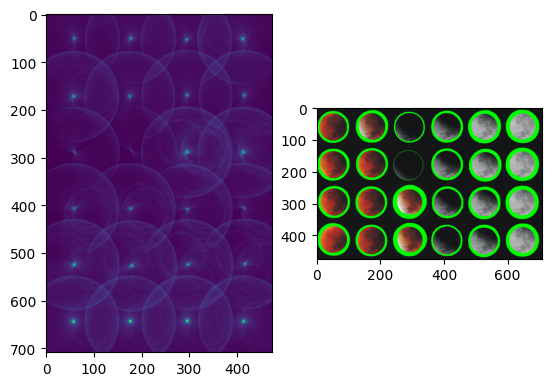

In [45]:
eclipse_gray = imread_gray("images/eclipse.jpg")
eclipse = cv2.imread("images/eclipse.jpg")
eclipse = cv2.cvtColor(eclipse, cv2.COLOR_BGR2RGB)

_,eclipse_edge = findedges(eclipse_gray, 1, 0.05)
eclipse_acc = find_circles(eclipse_edge, 47)

centers = np.where(eclipse_acc >= 83)

circles = eclipse.copy()
for y, x in zip(centers[0], centers[1]):
    cv2.circle(circles, (x, y), 47, (0, 255, 0), 1)

plt.subplot(1,2,1)
plt.imshow(eclipse_acc.T)
plt.subplot(1,2,2)
plt.imshow(circles)
plt.show()

### (h) Extend your algorithm so that it normalizes the number of votes according to the maximum number of votes possible for a given line (how many pixels does a line cover along its crossing of the image).

In [46]:
def hough_find_lines_normalised(image, theta_bins, rho_bins, thr, accumulator):
    
    thetas = np.linspace(-np.pi/2, np.pi/2, num=theta_bins)
    
    max_votes = np.zeros((accumulator.shape))
    
    for theta_index in range(theta_bins):
        for rho_index in range(rho_bins):
            
            theta = thetas[theta_index]
            
            if np.abs(np.sin(theta)) > np.abs(np.cos(theta)):
                line_length = image.shape[0] / np.abs(np.sin(theta))
            else:
                line_length = image.shape[1] / np.abs(np.cos(theta))

            max_votes[rho_index, theta_index] = line_length

    max_votes[max_votes == 0] = 1

    normalized = accumulator / max_votes

    normalized[normalized < thr] = 0
    
    return normalized

3.988262910798122
2.51400657759669


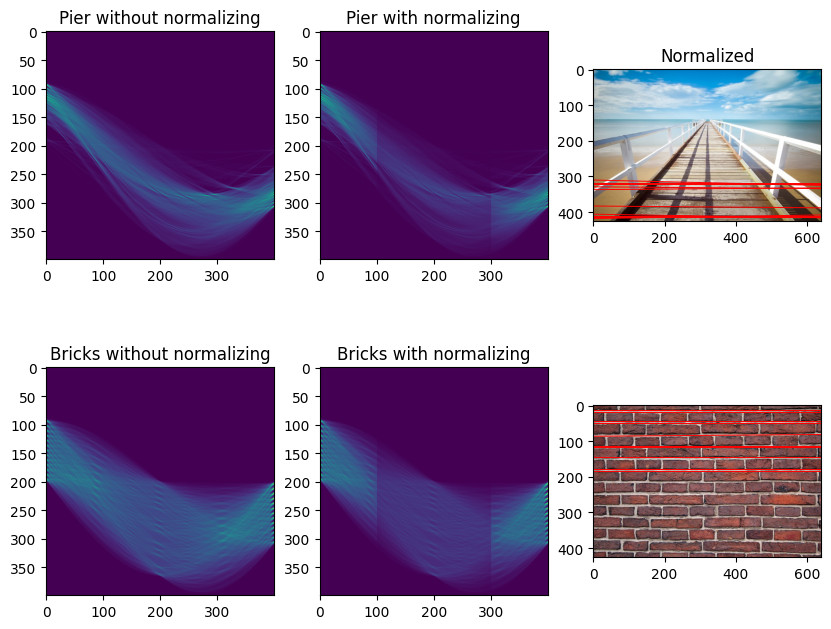

In [47]:

bricks_gray = imread_gray("images/bricks.jpg")
pier_gray = imread_gray("images/pier.jpg")
bricks_normalized = hough_find_lines_normalised(brick_hyst, 400,400, 0, brick_acc)
pier_normalized = hough_find_lines_normalised(pier_hyst, 400,400, 0, pier_acc)

 
pairs_brick_normal = find_pairs(brick_hyst, 400, 400, 0, bricks_normalized) 
pairs_brick_normal.sort(key=lambda x: x[2], reverse=True)

pairs_pier_normal = find_pairs(pier_hyst, 400, 400, 0, pier_normalized) 
pairs_pier_normal.sort(key=lambda x: x[2], reverse=True)

plt.figure(figsize=(10,8))
plt.subplot(2,3,1)
plt.imshow(pier_acc)
plt.title('Pier without normalizing')
plt.subplot(2,3,2)
plt.imshow(pier_normalized)
plt.title('Pier with normalizing')
plt.subplot(2,3,3)
plt.imshow(pier)
for pair in pairs_pier_normal[:10]:
    draw_line(pair[0], pair[1], pier.shape[0], pier.shape[1])
plt.title("Normalized")
plt.subplot(2,3,4)
plt.imshow(brick_acc)
plt.title('Bricks without normalizing')
plt.subplot(2,3,5)
plt.imshow(bricks_normalized)
plt.title('Bricks with normalizing')
plt.subplot(2,3,6)
plt.imshow(bricks)
for pair in pairs_brick_normal[:10]:
        draw_line(pair[0], pair[1], bricks.shape[0], bricks.shape[1])
plt.show()